In [1]:
import itertools
import functools
import contextlib
import base64
from io import BytesIO

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
from IPython.display import display, HTML

In [3]:
import asm
from gtemu import Emulator, RAM, ROM
import benchmark
from benchmark import _read_word as read_word

In [4]:
# All of these metrics are in cycles
_PER_INSTRUCTION_DATA = ['timeslice_on_entry', 'stall_in_vcpu', 'in_display_loop', 'execution_time', 'timeslice_on_exit']

_EMPTY_INSTRUCTION_DATA = dict((key, 0) for key in _PER_INSTRUCTION_DATA)

def _sign_extend(byte):
    return (byte & 0b0111_1111) - (byte & 0b1000_0000)

class Profiler:
    
    def __init__(self, emulator):
        self.emulator = emulator
        self._invocation_data = None
        self._instruction_data = None
        self.invocation_data = []
        self.current_invocation_instruction_data = None  # Dict of pc -> instruction data
        self.current_instruction_data = None # Instruction data
        # We use this all the time
        self._enter = asm.symbol('ENTER')
        # We also need to know when we're about to execute SYS
        self._sys = asm.symbol('SYS') & 0xff
        # maxTicks, but stored in cycles.
        self._max_cycles = 28
        self._vticks = 0x15
        
    def get_cycles_remaining(self):
        # We are at ENTER or NEXT.
        # If at ENTER, we're at the start of a timeslice and the length is in ac
        if self.emulator.next_instruction == self._enter:
            ticks_remaining = self.emulator.AC
        # if at NEXT, we've just tried an instruction. ac = the negative of the ticks taken.
        else:
            ticks_remaining = _sign_extend(self.emulator.AC) + RAM[self._vticks]
        # In both cases, the ticks remaining is offset by maxTicks
        # (and by vCPU_overhead, but that's constant, and so it's grouped as part of the displayloop)
        return ticks_remaining * 2 + self._max_cycles
        
    def get_instruction_about_to_execute(self):
        # Assuming we haven't executed next yet
        vpc_low, vpc_high = RAM[0x16: 0x18]
        return (vpc_low + 2) & 0xff | (vpc_high << 8)
    
    def begin_invocation(self):
        # Set up data structures
        self.current_invocation_instruction_data = {}
        self.invocation_data.append(self.current_invocation_instruction_data)
        
    def begin_instruction(self):
        # We don't handle loops
        instruction = self.get_instruction_about_to_execute()
        assert instruction not in self.current_invocation_instruction_data
        self.current_invocation_instruction_data[instruction] = self.current_instruction_data = _EMPTY_INSTRUCTION_DATA.copy()
        self.current_instruction_data['timeslice_on_entry'] = self.get_cycles_remaining()
    
    def step_vcpu_with_measurement(self):
        # We're about to step, but first, look ahead and see where we're going.
        # If we've got time to run an instruction, the time will count towards the instruction runtime.
        # If not, any time remaining will count towards stall, and we count two values, stall in vCPU and time in displayloop
        remaining_cycles = self.get_cycles_remaining()
        # If ticks_remaining >= maxTicks, we'll execute an instruction and time should be accounted as execution
        # UNLESS the instruction is SYS. 
        # If it's a SYS function, we need to check the operand, and if there's no time, it's a stall.
        if remaining_cycles >= self._max_cycles:
            dest = 'execution_time'     
            x = self.get_instruction_about_to_execute()
            instruction, operand = RAM[x: x+2]
            if instruction == self._sys:
                if self._max_cycles - _sign_extend(operand) * 2 > remaining_cycles:
                    dest = 'stall_in_vcpu'
        # But otherwise, we're going to return to the display loop.
        # We account for this as stall_in_vcpu being remaining_cycles, and the remainder as in_display_loop
        else:
            self.current_instruction_data['stall_in_vcpu'] += remaining_cycles
            self.current_instruction_data['in_display_loop'] -= remaining_cycles
            dest = 'in_display_loop'
                
        self.current_instruction_data[dest] += self.emulator.step_vcpu()
        
    def end_instruction(self):
        self.current_instruction_data['timeslice_on_exit'] = self.get_cycles_remaining()
            
    def profile_invocation(self):
        self.begin_invocation()
        target_instruction = self.emulator.vLR
        while target_instruction != self.get_instruction_about_to_execute():
            self.begin_instruction()
            v_pc = self.emulator.vPC # Used to see when we've moved
            while v_pc == self.emulator.vPC:
                self.step_vcpu_with_measurement()
            self.end_instruction()

In [5]:
my_symbols = benchmark._load(benchmark.MY_MANDELBROT)

In [6]:
cycles = benchmark._run_to_main_start()

Boot reached SYS_RESET_88 in 1006781 cycles (0.16108496s)
Boot reached SYS_Exec_88 (Reset) in 1006825 cycles (0.161092s)
Boot reached SYS_Exec_88 (Main) in 2037968 cycles (0.32607488s)
Program was ready to begin exectution after 3752667 cycles (0.60042672s)


In [7]:
profiler = Profiler(Emulator)
for _ in range(20_000):
    cycles += benchmark._run_to_function_entry(my_symbols, 'MulShift8')
    profiler.profile_invocation()

In [8]:
profiler.current_invocation_instruction_data

{514: {'timeslice_on_entry': 62,
  'stall_in_vcpu': 0,
  'in_display_loop': 0,
  'execution_time': 16,
  'timeslice_on_exit': 46},
 516: {'timeslice_on_entry': 46,
  'stall_in_vcpu': 0,
  'in_display_loop': 0,
  'execution_time': 20,
  'timeslice_on_exit': 26},
 518: {'timeslice_on_entry': 26,
  'stall_in_vcpu': 26,
  'in_display_loop': 652,
  'execution_time': 28,
  'timeslice_on_exit': 120},
 520: {'timeslice_on_entry': 120,
  'stall_in_vcpu': 0,
  'in_display_loop': 0,
  'execution_time': 28,
  'timeslice_on_exit': 92},
 529: {'timeslice_on_entry': 92,
  'stall_in_vcpu': 0,
  'in_display_loop': 0,
  'execution_time': 16,
  'timeslice_on_exit': 76},
 531: {'timeslice_on_entry': 76,
  'stall_in_vcpu': 0,
  'in_display_loop': 0,
  'execution_time': 28,
  'timeslice_on_exit': 48},
 533: {'timeslice_on_entry': 48,
  'stall_in_vcpu': 0,
  'in_display_loop': 0,
  'execution_time': 28,
  'timeslice_on_exit': 20},
 544: {'timeslice_on_entry': 20,
  'stall_in_vcpu': 20,
  'in_display_loop': 6

In [9]:
most_recent_trace = pd.DataFrame.from_dict(profiler.current_invocation_instruction_data, orient='index')
most_recent_trace.index.name = 'Instruction'
most_recent_trace

,timeslice_on_entry,stall_in_vcpu,in_display_loop,execution_time,timeslice_on_exit
Instruction,,,,,
514,62,0,0,16,46
516,46,0,0,20,26
518,26,26,652,28,120
520,120,0,0,28,92
529,92,0,0,16,76
531,76,0,0,28,48
533,48,0,0,28,20
544,20,20,652,22,126
546,126,0,0,16,110


In [10]:
xr.Dataset.from_dataframe(most_recent_trace)

<xarray.Dataset>
Dimensions:             (Instruction: 36)
Coordinates:
  * Instruction         (Instruction) int64 514 516 518 520 ... 594 596 605 607
Data variables:
    timeslice_on_entry  (Instruction) int64 62 46 26 120 92 ... 0 128 108 80 60
    stall_in_vcpu       (Instruction) int64 0 0 26 0 0 0 0 20 ... 48 0 0 0 0 0 0
    in_display_loop     (Instruction) int64 0 0 652 0 0 0 0 ... 0 652 0 0 0 0
    execution_time      (Instruction) int64 16 20 28 28 16 28 ... 20 20 28 20 20
    timeslice_on_exit   (Instruction) int64 46 26 120 92 76 ... 128 108 80 60 40

In [11]:
# I feel sure that there must be a better way!
frames = [pd.DataFrame.from_dict(d, orient='index') for d in profiler.invocation_data]
for f in frames: f.index.name = 'instruction'
sets = [xr.Dataset.from_dataframe(f) for f in frames]
del frames

In [12]:
invocation_data = xr.concat(sets, dim='invocation')
del sets
invocation_data['total_time'] = sum(invocation_data[metric] for metric in ['stall_in_vcpu', 'in_display_loop', 'execution_time'])
invocation_data

<xarray.Dataset>
Dimensions:             (instruction: 46, invocation: 20000)
Coordinates:
  * instruction         (instruction) int64 514 516 518 520 ... 601 603 605 607
Dimensions without coordinates: invocation
Data variables:
    timeslice_on_entry  (invocation, instruction) float64 14.0 132.0 ... 60.0
    stall_in_vcpu       (invocation, instruction) float64 14.0 0.0 ... 0.0 0.0
    in_display_loop     (invocation, instruction) float64 652.0 0.0 ... 0.0 0.0
    execution_time      (invocation, instruction) float64 16.0 20.0 ... 20.0
    timeslice_on_exit   (invocation, instruction) float64 132.0 112.0 ... 40.0
    total_time          (invocation, instruction) float64 682.0 20.0 ... 20.0

In [35]:
def show_distribution(variable, *markers, **kwargs):
    """Takes a variable, and returns a series of figures
    
    If markers are provided, they must also be a series.
    """
    def plot(instruction):
        fig, ax = plt.subplots(1, 1, figsize=(2, 0.5))
        for k,v in ax.spines.items():
            v.set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

        invocation_data.sel(instruction=instruction)[variable].plot.hist(ax=ax, **kwargs)
        for marker in markers:
            ax.axvline(x=marker[instruction], c='red')
        img = BytesIO()
        plt.savefig(img)
        img.seek(0)
        plt.close()
        return '<img src="data:image/png;base64,{}"/>'.format(base64.b64encode(img.read()).decode())

    return invocation_data.coords['instruction'].to_series().map(plot)

In [31]:
cols = pd.MultiIndex.from_product([['execution_time', 'total_time'], ['min', 'max', 'mean', 'distribution']])
stats = pd.DataFrame(columns=cols)
for var, metric in cols:
    if metric == 'distribution':
        stats[var, metric] = show_distribution(var, stats[var, 'mean'])
        continue
    data = getattr(invocation_data[var], metric)('invocation')
    if metric != 'mean':
        data = data.astype('uint')
    stats[var, metric] = data.to_series()
pd.options.display.float_format = '{:,.1f}'.format
pd.set_option('display.max_colwidth', None)

In [32]:
def disassemble(symbols, address):
    # Little vCPU disassembler copied from gt1dump.py
    """Return the string disassembly of the given address"""
    # Need the reverse mapping
    symbols = {v: k for k, v in symbols.items()}
    next_vpc = address
    opcode = RAM[next_vpc]
    # If we don't know a mnemonic, just use hex - no operands
    mnemonic, number_of_operands = _OPCODES.get(opcode, (f"${opcode:02x}", 0))
    asm_parts = [mnemonic]
    operands = bytearray(RAM[next_vpc + 1 : next_vpc + 1 + number_of_operands])
    while operands:
        # Poor man's switch statement
        if mnemonic in _ZP_MODE_OPCODES:
            operand = operands.pop(0)
            decoding = symbols.get(operand, '') or _ZERO_PAGE_SYMBOLS.get(operand, '') or f"${operand:02x}"
            asm_parts.append(decoding)
            continue
        if mnemonic == "Bcc":
            operand = operands.pop(0)
            if operand in _BCC_CODES:
                asm_parts = [f"B{_BCC_CODES[operand]}"]
            # Fall through
        if mnemonic in {"Bcc", "BRA", "DEF"}:
            # Next operand is a target within a page
            operand = operands.pop(0)
            target = next_vpc & 0xFF00 | (operand + 2) & 0xFF
            asm_parts.append(f"${target:04x}")
            continue
        if mnemonic == "SYS":
            operand = operands.pop(0)
            if operand != 128:
                max_cycles = 28 - 2 * ((operand ^ 128) - 128)
                asm_parts.append(str(max_cycles))
            else:
                asm_parts = ["HALT"]
            continue
        # Else...
        # Treat any remaining bytes as a single operand
        operand = int.from_bytes(operands, "little", signed=False)
        asm_parts.append(f"${operand:02x}" if len(operands) == 1 else f"${operand:04x}")
        break
    return f"{address:04x}    {bytes(RAM[next_vpc : next_vpc + 1 + number_of_operands]).hex()}    {' '.join(asm_parts)}"


_OPCODES = {
    0x11: ("LDWI", 2),
    0x1A: ("LD", 1),
    0x1F: ("CMPHS", 1),
    0x21: ("LDW", 1),
    0x2B: ("STW", 1),
    0x35: ("Bcc", 2),
    0x59: ("LDI", 1),
    0x5E: ("ST", 1),
    0x63: ("POP", 0),
    0x75: ("PUSH", 0),
    0x7F: ("LUP", 1),
    0x82: ("ANDI", 1),
    0x85: ("CALLI", 2),
    0x88: ("ORI", 1),
    0x8C: ("XORI", 1),
    0x90: ("BRA", 1),
    0x93: ("INC", 1),
    0x97: ("CMPHU", 1),
    0x99: ("ADDW", 1),
    0xAD: ("PEEK", 0),
    0xB4: ("SYS", 1),
    0xB8: ("SUBW", 1),
    0xCD: ("DEF", 1),
    0xCF: ("CALL", 1),
    0xDF: ("ALLOC", 1),
    0xE3: ("ADDI", 1),
    0xE6: ("SUBI", 1),
    0xE9: ("LSLW", 0),
    0xEC: ("STLW", 1),
    0xEE: ("LDLW", 1),
    0xF0: ("POKE", 1),
    0xF3: ("DOKE", 1),
    0xF6: ("DEEK", 0),
    0xF8: ("ANDW", 1),
    0xFA: ("ORW", 1),
    0xFC: ("XORW", 1),
    0xFF: ("RET", 0),
}

_BCC_CODES = {
    0x3F: "EQ",
    0x4D: "GT",
    0x50: "LT",
    0x53: "GE",
    0x56: "LE",
    0x72: "NE",
}

_ZERO_PAGE_SYMBOLS = {
    0x00: "zeroConst",
    0x01: "memSize",
    0x06: "entropy",
    0x09: "videoY",
    0x0E: "frameCount",
    0x0F: "serialRaw",
    0x11: "buttonState",
    0x14: "xoutMask",
    0x16: "vPC",
    0x17: "vPC+1",
    0x18: "vAC",
    0x19: "vAC+1",
    0x1A: "vLR",
    0x1B: "vLR+1",
    0x1C: "vSP",
    0x21: "romType",
    0x22: "sysFn",
    0x23: "sysFn+1",
    0x24: "sysArgs+0",
    0x25: "sysArgs+1",
    0x26: "sysArgs+2",
    0x27: "sysArgs+3",
    0x28: "sysArgs+4",
    0x29: "sysArgs+5",
    0x2A: "sysArgs+6",
    0x2B: "sysArgs+7",
    0x2C: "soundTimer",
    0x2E: "ledState_v2",
    0x2F: "ledTempo",
    0x80: "oneConst",
}

# Opcodes that address page zero
_ZP_MODE_OPCODES = {
    "LD",
    "LDW",
    "STW",
    "ST",
    "INC",
    "ADDW",
    "SUBW",
    "CALL",
    "POKE",
    "DOKE",
    "ANDW",
    "ORW",
    "XORW",
    "CMPHS",
    "CMPHU",
}


In [33]:
decoding = invocation_data.coords['instruction'].to_series().map(lambda a: disassemble(my_symbols, a))
stats.index = decoding
pd.set_option('display.max_colwidth', None)
HTML(stats.to_html(escape=False))


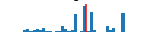
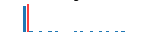
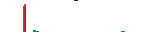
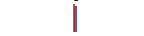
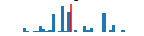
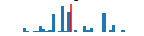
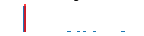
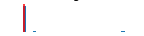
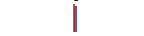
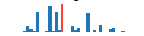
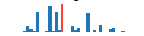
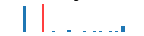
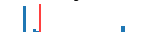
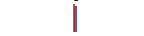
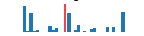
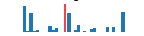
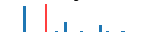
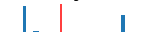
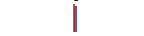
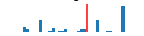
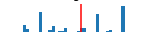
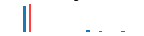
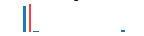
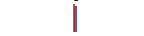
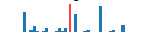
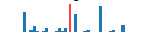
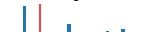
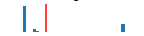
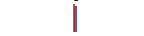
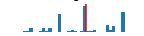
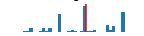
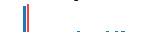
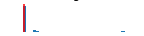
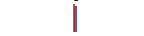
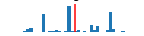
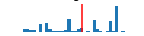
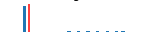
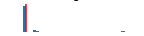
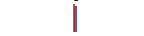
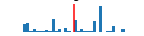
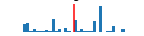
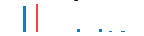
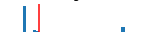
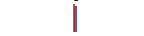
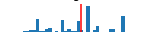
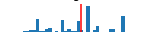
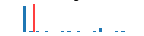
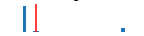
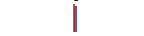
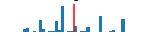
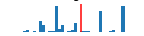
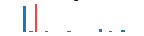
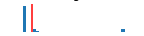
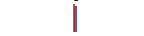
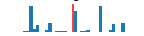
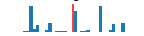
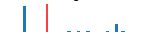
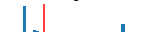
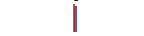
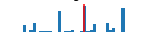
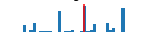
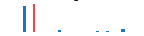
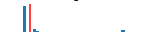
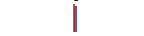
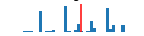
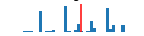
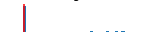
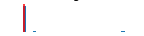
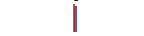
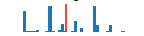
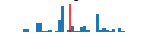
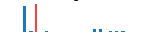
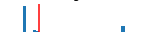
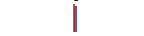
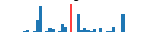
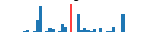
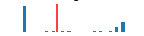
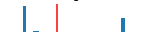
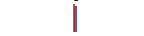
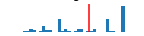
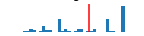
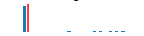
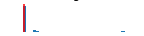
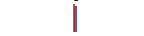
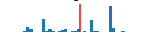
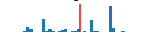
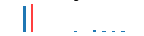
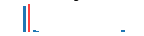
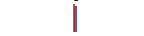
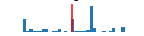
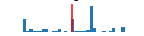
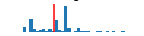
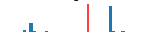
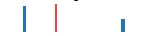
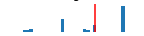
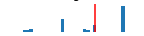
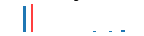
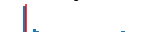
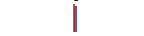
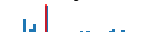
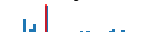
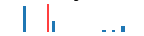
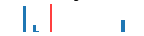
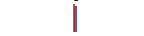
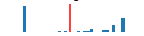
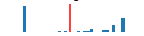
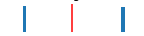
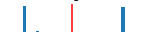
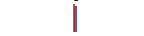
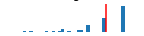
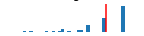
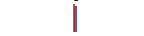
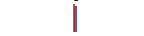
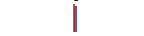
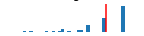
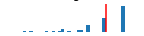
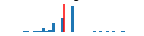
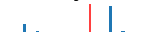
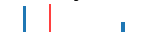
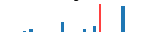
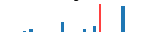
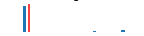
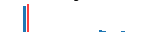
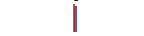
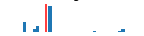
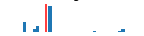
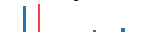
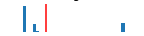
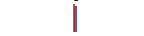
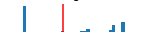
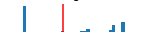
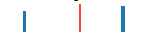
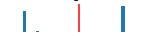
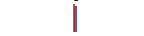
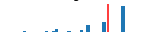
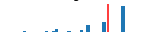
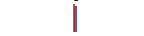
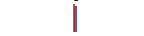
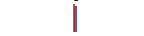
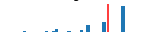
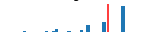
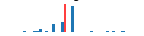
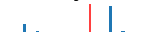
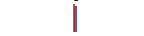
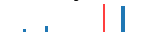
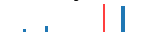
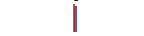
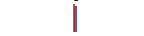
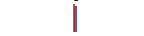
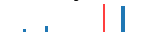
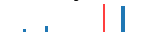
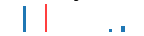
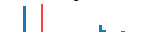
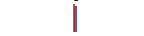
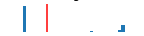
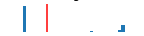
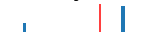
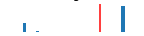
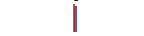
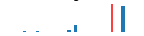
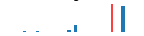
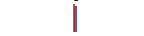
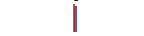
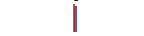
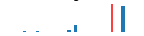
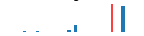
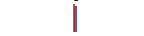
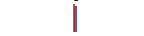
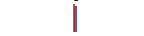
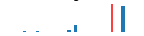
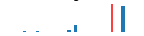
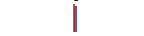
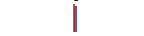
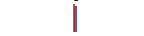
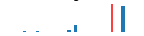
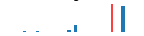
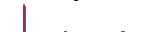
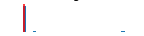
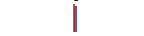
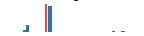
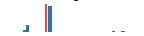
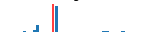
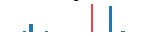
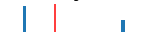
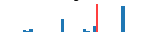
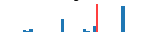
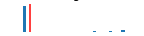
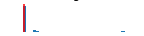
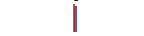
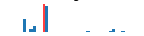
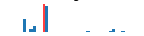
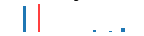
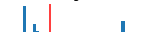
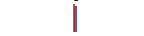
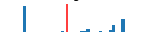
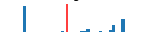
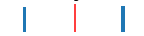
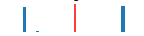
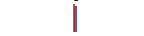
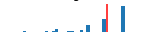
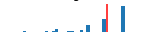
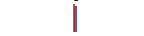
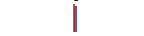
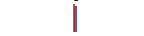
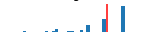
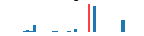
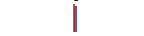
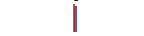
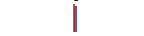
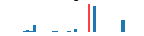
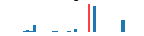
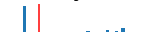
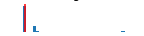
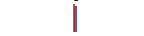
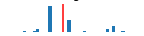
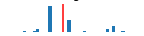
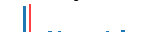
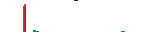
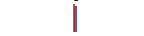
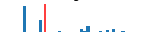
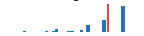
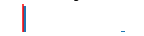
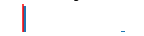
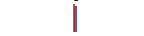
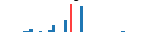
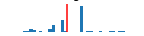
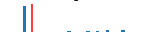
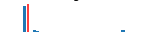
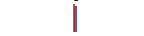
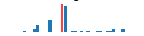

In [36]:
cols = pd.MultiIndex.from_product([_PER_INSTRUCTION_DATA, ['min', 'max', 'mean', 'distribution']])
detailed = pd.DataFrame(columns=cols)
for var, metric in cols:
    if metric == 'distribution':
        detailed[var, metric] = show_distribution(var, detailed[var, 'mean'], bins=32)
        continue
    data = getattr(invocation_data[var], metric)('invocation')
    if metric != 'mean':
        data = data.astype('uint')
    detailed[var, metric] = data.to_series()
detailed.index = decoding
HTML(detailed.to_html(escape=False))

In [17]:
invocation_data['execution_time'].count('invocation').rename('invocations').to_dataframe()

,invocations
instruction,
514,20000
516,20000
518,20000
520,20000
523,8552
525,8552
527,8552
529,20000
531,20000


In [18]:
totals = invocation_data.sum('invocation').sum('instruction')[['execution_time', 'stall_in_vcpu', 'in_display_loop', 'total_time']]
percentages = totals / totals['total_time'] * 100
percentages.expand_dims('Percentage').to_dataframe()

,execution_time,stall_in_vcpu,in_display_loop,total_time
Percentage,,,,
0,16.6,5.9,77.5,100.0
